In [30]:
import os
import re
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import Dataset
from konlpy.tag import Komoran
from pykospacing import Spacing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from transformers import ElectraTokenizer, ElectraForSequenceClassification, Trainer, TrainingArguments, AdamW
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
import optuna
import itertools
import h5py

In [2]:
# GPU 설정 : PyTorch를 사용할 때, GPU가 사용 가능한 경우 "cuda"를 사용하고, 그렇지 않으면 CPU("cpu")를 사용하도록 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

komoran = Komoran()                 # Komoran 객체 생성: 한국어 형태소 분석기 Komoran을 초기화
spacing = Spacing()                 # Spacing 객체 생성: 텍스트에서 띄어쓰기를 자동으로 교정해주는 Spacing 라이브러리를 초기화
label_encoder = LabelEncoder()      # LabelEncoder 객체 생성: 범주형 데이터를 수치형 데이터로 변환하는 LabelEncoder를 초기화

# tqdm과 pandas 통합: pandas의 프로그레스 바 기능을 tqdm과 통합하여 데이터프레임의 연산 시 진행 상황을 시각적으로 표시
tqdm.pandas()

# 엑셀 파일에서 데이터 읽어오기: 지정된 경로에서 'samsung_news_fil_cleaned.xlsx' 엑셀 파일을 읽어와서 데이터프레임에 저장
df = pd.read_excel(r'../../../data/samsung_news_fil_cleaned.xlsx')

# 데이터의 일부만 가져오기 (처음 10000개 행): 전체 데이터가 클 경우 처음 10000개 행만 사용하도록 하는 코드
# df = df.iloc[:10000]

In [3]:
# 호재 악재 갯수 확인
print("Class distribution:")
print(df['Outcome'].value_counts())

Class distribution:
Outcome
호재    9345
악재    3861
Name: count, dtype: int64


In [4]:
# Outcome 레이블 변경
# 'Outcome' : '호재'는 0으로, '악재'는 1로 변경하여 이진 분류 문제로 변환
df.loc[(df['Outcome'] == '호재'), 'Outcome'] = 0
df.loc[(df['Outcome'] == '악재'), 'Outcome'] = 1

# 클래스별로 데이터 분리
# 'Outcome' 값에 따라 두 개의 데이터프레임으로 분리
df_positive = df[df['Outcome'] == 0]  # 0: 호재
df_negative = df[df['Outcome'] == 1]  # 1: 악재

# 최소 클래스의 샘플 수 확인
# 더 적은 샘플 수를 가진 클래스를 찾아 그 개수를 저장
min_class_count = min(len(df_positive), len(df_negative))

# 최소 샘플 수 보장 및 계산
# 샘플 수를 보정, 최소 클래스의 1.25배 및 1.35배가 되도록 설정
positive_n_samples = max(int(min_class_count * 1.25), 1)
negative_n_samples = max(int(min_class_count * 1.35), 1)

# 다운샘플링 적용
df_positive_downsampled = resample(df_positive,
                                   replace=True,                    # 샘플을 복원하지 않고
                                   n_samples=positive_n_samples,    # 최소 클래스의 개수에 비례해서 설정
                                   random_state=42)                 # 재현성을 위해 random_state 사용

df_negative_downsampled = resample(df_negative,
                                   replace=True,                    # 샘플을 복원하지 않고
                                   n_samples=negative_n_samples,    # 최소 클래스의 개수에 비례해서 설정
                                   random_state=42)                 # 재현성을 위해 random_state 사용

# 다운샘플링된 데이터 결합
df_resampled = pd.concat([df_positive_downsampled, df_negative_downsampled])

# 데이터프레임을 무작위로 셔플, 인덱스 초기화, 데이터의 순서를 랜덤 배치 
df_resampled = df_resampled.sample(frac=1, random_state=42).reset_index(drop=True)

# 데이터를 학습용(train)과 평가용(eval)으로 8:2 비율로 분리
train_df, eval_df = train_test_split(df_resampled, test_size=0.2, random_state=42)

# 학습 데이터의 텍스트와 라벨을 리스트로 변환
train_texts     = train_df['cleaned'].tolist()
train_labels    = train_df['Outcome'].tolist()

# 평가 데이터의 텍스트와 라벨을 리스트로 변환
eval_texts      = eval_df['cleaned'].tolist()
eval_labels     = eval_df['Outcome'].tolist()

In [5]:
# PyTorch Dataset 클래스 정의 / 학습 및 평가에 사용할 데이터셋 정의
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        # 생성자에서 텍스트 데이터, 라벨, 토크나이저, 최대 길이를 초기화
        self.texts      = texts                             # 텍스트 데이터 리스트
        self.labels     = labels                            # 라벨 데이터 리스트
        self.tokenizer  = tokenizer                         # 사용할 토크나이저
        self.max_len    = max_len                           # 토큰화된 시퀀스의 최대 길이

    def __len__(self):
        # 데이터셋 샘플 수 반환
        return len(self.texts)

    def __getitem__(self, idx):
        # 주어진 인덱스 해당하는 텍스트와 라벨을 반환
        text    = self.texts[idx]                           # 인덱스에 해당하는 텍스트
        label   = self.labels[idx]                          # 인덱스에 해당하는 라벨

        # 텍스트를 토크나이저로 인코딩, 모델 입력으로 변환
        encoding = self.tokenizer.encode_plus(
            text,                                           # 인코딩할 텍스트
            add_special_tokens      = True,                 # 문장의 시작과 끝에 특별 토큰 추가
            max_length              = self.max_len,         # 최대 길이로 패딩 및 자르기 수행
            return_token_type_ids   = False,                # token type ids 반환 안함
            padding                 = 'max_length',         # max_length에 맞춰 패딩 추가
            truncation              = True,                 # max_length를 초과하는 텍스트는 자름
            return_attention_mask   = True,                 # attention mask 반환
            return_tensors          = 'pt',                 # PyTorch 텐서로 반환
        )

        # 반환된 인코딩 결과를 딕셔너리 형태로 반환
        return {
            'input_ids': encoding['input_ids'].flatten(),               # 토큰 ID 텐서를 1차원으로 평탄화하여 반환
            'attention_mask': encoding['attention_mask'].flatten(),     # attention mask 텐서를 1차원으로 평탄화하여 반환
            'labels': torch.tensor(label, dtype=torch.long)             # 라벨을 long 타입의 텐서로 변환하여 반환
        }

In [6]:
# KcELECTRA 토크나이저 로드
tokenizer = ElectraTokenizer.from_pretrained("beomi/KcELECTRA-base-v2022")

# 모델 초기화 함수 정의 / KcELECTRA 기반의 시퀀스 분류 모델 초기화
def initialize_model():
    # num_labels=2로 이진 분류를 수행하도록 설정 / 사전 학습된 KcELECTRA 모델 불러오기, 시퀀스 분류를 위해 사용
    model = ElectraForSequenceClassification.from_pretrained("beomi/KcELECTRA-base-v2022", num_labels=2)
    
    # 모델 GPU로 이동
    model.to(device)

    # 옵티마이저로 AdamW 설정, 학습률은 5e-5 설정
    optimizer = AdamW(model.parameters(), lr=5e-5)
    
    return model, optimizer

# 평가지표를 계산하는 함수 정의
def compute_metrics(eval_pred):
    # 예측 결과와 실제 라벨 분리
    logits, labels = eval_pred.predictions, eval_pred.label_ids

    # 예측 로짓에서 가장 높은값으로 최종 만듬
    predictions = torch.argmax(torch.tensor(logits), dim=1)
    
    # 예측값과 실제 라벨 비교 후 정확도 계산
    acc = accuracy_score(labels, predictions.numpy())
    
    # precision, recall, f1 점수를 가중 평균 방식(average='weighted')으로 계산
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions.numpy(), average='weighted')
    
    # 계산된 지표들 딕셔너리 형태로 반환
    return {
        'accuracy'  : acc,
        'f1'        : f1,
        'precision' : precision,
        'recall'    : recall
    }

# 전처리된 텍스트와 라벨로 학습 및 평가 데이터셋 인스턴스 생성
train_dataset = NewsDataset(train_texts, train_labels, tokenizer, max_len=256)
eval_dataset = NewsDataset(eval_texts, eval_labels, tokenizer, max_len=256)

c:\Users\dlavk\anaconda3\envs\test_pytorch\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'ElectraTokenizer'.


In [28]:
# 로그를 저장할 리스트 초기화
log_list = []

# 하이퍼파라미터 그리드 설정
parameter_grid = {
    'learning_rate': [1e-5, 3e-5],  # 학습률: 적당히 넓은 범위에서 선택 
    'batch_size': [16],             # 배치 크기
    'num_train_epochs': [5],        # 학습 에폭 수
    'weight_decay': [0.01, 0.005],  # 가중치 감소 , 과적합 방지를 위해 작은값 추가 
    'warmup_steps': [500],          # 웜업 스텝수 
}

# 최적화된 하이퍼파라미터를 저장할 변수
best_accuracy = 0
best_params = None
best_model = None

In [31]:
# 하이퍼파라미터 그리드의 모든 조합 생성
param_combinations = list(itertools.product(*parameter_grid.values()))

In [32]:
# 하이퍼파라미터 그리드 조합 확인
param_combinations

[(1e-05, 16, 5, 0.01, 500),
 (1e-05, 16, 5, 0.005, 500),
 (3e-05, 16, 5, 0.01, 500),
 (3e-05, 16, 5, 0.005, 500)]

In [33]:
# 그리드 서치 시작
for param_set in param_combinations:
    # 각 하이퍼파라미터 조합을 변수에 할당
    learning_rate, batch_size, num_train_epochs, weight_decay, warmup_steps = param_set
    
    # 현재 조합에 대한 정보를 출력
    print(f"Testing combination: LR: {learning_rate}, Batch Size: {batch_size}, Epochs: {num_train_epochs}, WD: {weight_decay}, Warmup Steps: {warmup_steps}")

    # 모델과 옵티마이저 초기화 (사용자 정의 함수로 가정)
    model, optimizer = initialize_model()

    # TrainingArguments 설정
    training_args = TrainingArguments(
        output_dir                  = './results',          # 학습 결과를 저장할 디렉토리
        num_train_epochs            = num_train_epochs,     # 학습 에폭 수
        per_device_train_batch_size = batch_size,           # 훈련 배치 크기
        per_device_eval_batch_size  = batch_size,           # 평가 배치 크기
        warmup_steps                = warmup_steps,         # 웜업 스텝 수
        weight_decay                = weight_decay,         # 가중치 감소 비율
        logging_dir                 = './logs',             # 로그를 저장할 디렉토리
        logging_steps               = 50,                   # 로그를 기록할 스텝 간격
        evaluation_strategy         = "epoch",              # 에폭마다 평가 수행
        save_total_limit            = 1,                    # 최대 1개의 체크포인트만 저장
        save_strategy               = "epoch",              # 에폭마다 모델을 저장
        load_best_model_at_end      = True,                 # 학습 종료 시 가장 좋은 모델을 로드
        gradient_accumulation_steps = 2,                    # 그래디언트 누적 스텝 수
        no_cuda                     = False,                # CUDA 사용 여부 (False로 설정하면 GPU를 사용)
        learning_rate               = learning_rate,        # 학습률
        report_to                   = "none",               # 로깅을 어디로 보낼지 설정 (none이면 로깅하지 않음)
    )

    # Trainer 설정
    trainer = Trainer(
        model                       = model,                # 학습할 모델
        args                        = training_args,        # 학습 설정
        train_dataset               = train_dataset,        # 훈련 데이터셋
        eval_dataset                = eval_dataset,         # 평가 데이터셋
        compute_metrics             = compute_metrics,      # 평가지표 계산 함수
        optimizers                  = (optimizer, None)     # 옵티마이저 설정
    )

    try:
        # 모델 학습
        trainer.train()

        # 모델 평가
        eval_results = trainer.evaluate()

        # 평가 지표를 로그 리스트에 저장 /  조합 평가 결과를 기록
        log_list.append({
            'epoch'         : num_train_epochs,
            'learning_rate' : learning_rate,
            'batch_size'    : batch_size,
            'weight_decay'  : weight_decay,
            'warmup_steps'  : warmup_steps,
            'eval_loss'     : eval_results.get('eval_loss'),
            'eval_accuracy' : eval_results.get('eval_accuracy'),
            'eval_f1'       : eval_results.get('eval_f1'),
            'eval_precision': eval_results.get('eval_precision'),
            'eval_recall'   : eval_results.get('eval_recall')
        })

        # 현재 에폭과 평가 결과 출력
        print(f"Results:")
        print(f"Epoch {num_train_epochs} | LR: {learning_rate} | Batch Size: {batch_size} | WD: {weight_decay} | Warmup: {warmup_steps}")
        print(f"Loss: {eval_results['eval_loss']:.4f} | Acc: {eval_results['eval_accuracy']:.4f} | F1: {eval_results['eval_f1']:.4f} | Prec: {eval_results['eval_precision']:.4f} | Rec: {eval_results['eval_recall']:.4f}")
        print("-" * 50)

        # 최적의 하이퍼파라미터 및 모델 업데이트
        if eval_results['eval_accuracy'] > best_accuracy:
            best_accuracy = eval_results['eval_accuracy']
            best_params = {
                'learning_rate'     : learning_rate,
                'batch_size'        : batch_size,
                'num_train_epochs'  : num_train_epochs,
                'weight_decay'      : weight_decay,
                'warmup_steps'      : warmup_steps
            }
            best_model = model

    except Exception as e:
        print(f"An error occurred during training: {e}")

# 최적의 하이퍼파라미터 출력
print(f"Best Accuracy: {best_accuracy}")
print(f"Best Hyperparameters: {best_params}")

# 로그를 DataFrame으로 변환하여 출력
df_logs = pd.DataFrame(log_list)
print(df_logs)

Testing combination: LR: 1e-05, Batch Size: 16, Epochs: 5, WD: 0.01, Warmup Steps: 500


c:\Users\dlavk\anaconda3\envs\test_pytorch\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\dlavk\anaconda3\envs\test_pytorch\Lib\site-packages\transformers\modeling_utils.py:484: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly a

{'loss': 0.6931, 'learning_rate': 5e-06, 'epoch': 0.2}


  8%|▊         | 100/1255 [02:25<27:55,  1.45s/it]

{'loss': 0.6936, 'learning_rate': 1e-05, 'epoch': 0.4}


 12%|█▏        | 150/1255 [03:37<26:57,  1.46s/it]

{'loss': 0.6724, 'learning_rate': 1.5e-05, 'epoch': 0.6}


 16%|█▌        | 200/1255 [04:49<24:55,  1.42s/it]

{'loss': 0.6095, 'learning_rate': 2e-05, 'epoch': 0.8}


 20%|█▉        | 250/1255 [06:03<24:24,  1.46s/it]

{'loss': 0.5853, 'learning_rate': 2.5e-05, 'epoch': 1.0}


 20%|██        | 251/1255 [06:30<23:07,  1.38s/it]

{'eval_loss': 0.5545030832290649, 'eval_accuracy': 0.6862549800796812, 'eval_f1': 0.656681350076372, 'eval_precision': 0.7593611869439794, 'eval_recall': 0.6862549800796812, 'eval_runtime': 26.1739, 'eval_samples_per_second': 76.718, 'eval_steps_per_second': 4.814, 'epoch': 1.0}


 24%|██▍       | 300/1255 [07:44<23:08,  1.45s/it]  

{'loss': 0.5698, 'learning_rate': 3e-05, 'epoch': 1.2}


 28%|██▊       | 350/1255 [08:58<22:12,  1.47s/it]

{'loss': 0.604, 'learning_rate': 3.5e-05, 'epoch': 1.39}


 32%|███▏      | 400/1255 [10:12<21:00,  1.47s/it]

{'loss': 0.5543, 'learning_rate': 4e-05, 'epoch': 1.59}


 36%|███▌      | 450/1255 [11:27<19:40,  1.47s/it]

{'loss': 0.5975, 'learning_rate': 4.5e-05, 'epoch': 1.79}


 40%|███▉      | 500/1255 [12:42<18:42,  1.49s/it]

{'loss': 0.5197, 'learning_rate': 5e-05, 'epoch': 1.99}


 40%|████      | 502/1255 [13:11<17:35,  1.40s/it]

{'eval_loss': 0.5106509923934937, 'eval_accuracy': 0.6937250996015937, 'eval_f1': 0.6567039977828358, 'eval_precision': 0.8071944151106418, 'eval_recall': 0.6937250996015937, 'eval_runtime': 26.678, 'eval_samples_per_second': 75.268, 'eval_steps_per_second': 4.723, 'epoch': 2.0}


 44%|████▍     | 550/1255 [14:26<17:20,  1.48s/it]  

{'loss': 0.5394, 'learning_rate': 4.668874172185431e-05, 'epoch': 2.19}


 48%|████▊     | 600/1255 [15:39<15:50,  1.45s/it]

{'loss': 0.5381, 'learning_rate': 4.337748344370861e-05, 'epoch': 2.39}


 52%|█████▏    | 650/1255 [16:53<14:49,  1.47s/it]

{'loss': 0.5555, 'learning_rate': 4.006622516556292e-05, 'epoch': 2.59}


 56%|█████▌    | 700/1255 [18:05<13:22,  1.45s/it]

{'loss': 0.5198, 'learning_rate': 3.675496688741722e-05, 'epoch': 2.79}


 60%|█████▉    | 750/1255 [19:17<12:13,  1.45s/it]

{'loss': 0.5054, 'learning_rate': 3.3443708609271526e-05, 'epoch': 2.99}


 60%|██████    | 753/1255 [19:46<11:31,  1.38s/it]

{'eval_loss': 0.5061969757080078, 'eval_accuracy': 0.6937250996015937, 'eval_f1': 0.6567039977828358, 'eval_precision': 0.8071944151106418, 'eval_recall': 0.6937250996015937, 'eval_runtime': 24.9548, 'eval_samples_per_second': 80.466, 'eval_steps_per_second': 5.049, 'epoch': 3.0}


 64%|██████▎   | 800/1255 [20:58<10:59,  1.45s/it]  

{'loss': 0.5072, 'learning_rate': 3.0132450331125826e-05, 'epoch': 3.19}


 68%|██████▊   | 850/1255 [22:11<09:48,  1.45s/it]

{'loss': 0.5203, 'learning_rate': 2.6821192052980134e-05, 'epoch': 3.39}


 72%|███████▏  | 900/1255 [23:24<08:31,  1.44s/it]

{'loss': 0.5064, 'learning_rate': 2.3509933774834437e-05, 'epoch': 3.59}


 76%|███████▌  | 950/1255 [24:36<07:28,  1.47s/it]

{'loss': 0.5278, 'learning_rate': 2.0198675496688745e-05, 'epoch': 3.78}


 80%|███████▉  | 1000/1255 [25:52<06:15,  1.47s/it]

{'loss': 0.499, 'learning_rate': 1.688741721854305e-05, 'epoch': 3.98}


 80%|████████  | 1004/1255 [26:23<06:01,  1.44s/it]

{'eval_loss': 0.5048550367355347, 'eval_accuracy': 0.6937250996015937, 'eval_f1': 0.6567039977828358, 'eval_precision': 0.8071944151106418, 'eval_recall': 0.6937250996015937, 'eval_runtime': 25.6317, 'eval_samples_per_second': 78.34, 'eval_steps_per_second': 4.916, 'epoch': 4.0}


 84%|████████▎ | 1050/1255 [27:36<05:01,  1.47s/it]

{'loss': 0.5105, 'learning_rate': 1.3576158940397351e-05, 'epoch': 4.18}


 88%|████████▊ | 1100/1255 [28:49<03:42,  1.43s/it]

{'loss': 0.5154, 'learning_rate': 1.0264900662251655e-05, 'epoch': 4.38}


 92%|█████████▏| 1150/1255 [30:01<02:31,  1.44s/it]

{'loss': 0.508, 'learning_rate': 6.95364238410596e-06, 'epoch': 4.58}


 96%|█████████▌| 1200/1255 [31:13<01:18,  1.43s/it]

{'loss': 0.5114, 'learning_rate': 3.642384105960265e-06, 'epoch': 4.78}


100%|█████████▉| 1250/1255 [32:25<00:07,  1.44s/it]

{'loss': 0.5042, 'learning_rate': 3.3112582781456954e-07, 'epoch': 4.98}


100%|██████████| 1255/1255 [32:58<00:00,  1.36s/it]

{'eval_loss': 0.504021942615509, 'eval_accuracy': 0.6937250996015937, 'eval_f1': 0.6567039977828358, 'eval_precision': 0.8071944151106418, 'eval_recall': 0.6937250996015937, 'eval_runtime': 25.8354, 'eval_samples_per_second': 77.723, 'eval_steps_per_second': 4.877, 'epoch': 5.0}


c:\Users\dlavk\anaconda3\envs\test_pytorch\Lib\site-packages\transformers\trainer.py:2261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_p

{'train_runtime': 1983.019, 'train_samples_per_second': 20.247, 'train_steps_per_second': 0.633, 'train_loss': 0.5543638596021797, 'epoch': 5.0}


100%|██████████| 126/126 [00:24<00:00,  5.05it/s]
c:\Users\dlavk\anaconda3\envs\test_pytorch\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Results:
Epoch 5 | LR: 1e-05 | Batch Size: 16 | WD: 0.01 | Warmup: 500
Loss: 0.5040 | Acc: 0.6937 | F1: 0.6567 | Prec: 0.8072 | Rec: 0.6937
--------------------------------------------------
Testing combination: LR: 1e-05, Batch Size: 16, Epochs: 5, WD: 0.005, Warmup Steps: 500


c:\Users\dlavk\anaconda3\envs\test_pytorch\Lib\site-packages\transformers\modeling_utils.py:484: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_f

{'loss': 0.6954, 'learning_rate': 5e-06, 'epoch': 0.2}


  8%|▊         | 100/1255 [06:22<1:13:41,  3.83s/it]

{'loss': 0.693, 'learning_rate': 1e-05, 'epoch': 0.4}


 12%|█▏        | 150/1255 [09:34<1:10:21,  3.82s/it]

{'loss': 0.6854, 'learning_rate': 1.5e-05, 'epoch': 0.6}


 15%|█▌        | 194/1255 [12:25<1:09:07,  3.91s/it]

KeyboardInterrupt: 

100%|██████████| 126/126 [00:25<00:00,  5.00it/s]


Training Accuracy: 0.6909090909090909
Validation Accuracy: 0.6967131474103586

Accuracy on Validation Set: 0.6967131474103586
Confusion Matrix on Validation Set:
 [[ 386  577]
 [  32 1013]]
Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       0.92      0.40      0.56       963
           1       0.64      0.97      0.77      1045

    accuracy                           0.70      2008
   macro avg       0.78      0.69      0.66      2008
weighted avg       0.77      0.70      0.67      2008



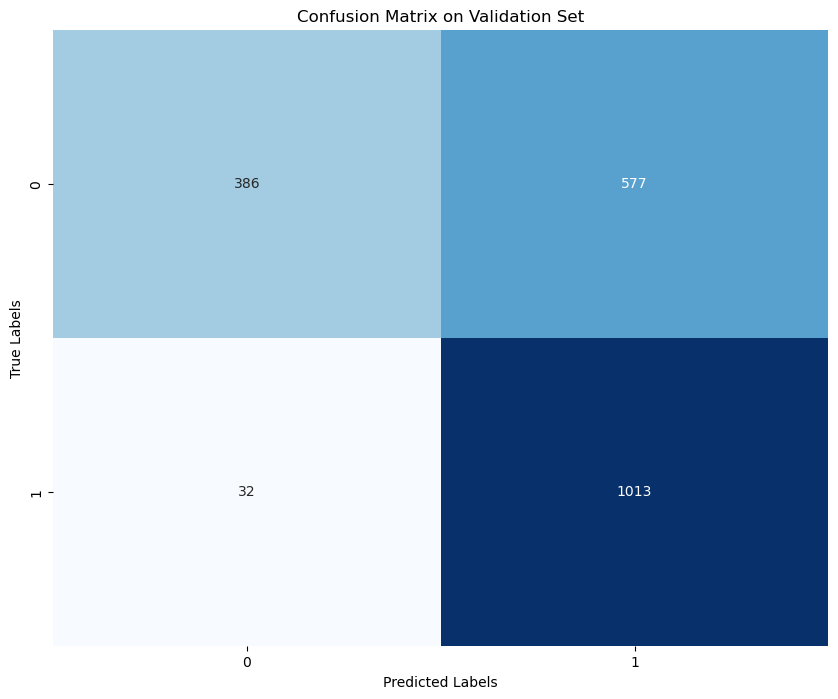

The model may be underfitting.


In [14]:
# 훈련 데이터에 대한 평가
train_results = trainer.evaluate(train_dataset)

# 검증 데이터에 대한 평가
eval_results = trainer.evaluate(eval_dataset)

# 검증 데이터에 대한 예측 수행
y_pred = trainer.predict(eval_dataset).predictions.argmax(-1)

# 평가 결과 출력
print("Training Accuracy:", train_results['eval_accuracy'])
print("Validation Accuracy:", eval_results['eval_accuracy'])

# 검증 데이터에서의 정확도, 혼동행렬, 분류 보고서를 출력
print("\nAccuracy on Validation Set:", accuracy_score(eval_labels, y_pred))
print("Confusion Matrix on Validation Set:\n", confusion_matrix(eval_labels, y_pred))
print("Classification Report on Validation Set:\n", classification_report(eval_labels, y_pred))

# 혼동행렬 계산 및 시각화
conf_matrix = confusion_matrix(eval_labels, y_pred)

plt.figure(figsize=(10, 8))  
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)           # 혼동행렬을 히트맵으로 시각화
plt.title('Confusion Matrix on Validation Set')
plt.xlabel('Predicted Labels') 
plt.ylabel('True Labels')  
plt.show()  

# 훈련 데이터와 검증 데이터의 정확도를 비교하여 과대적합/과소적합 판별
train_accuracy = train_results['eval_accuracy']                                   # 훈련 데이터에서의 정확도
val_accuracy = eval_results['eval_accuracy']                                      # 검증 데이터에서의 정확도

# 훈련 데이터의 정확도가 검증 데이터보다 현저히 높을 경우 과대적합 가능성을 제시
if train_accuracy > val_accuracy and (train_accuracy - val_accuracy) > 0.05:
    print("The model may be overfitting.")
# 훈련 데이터의 정확도가 검증 데이터보다 낮을 경우 과소적합 가능성을 제시
elif train_accuracy < val_accuracy:
    print("The model may be underfitting.")
# 훈련 데이터와 검증 데이터의 정확도가 유사할 경우 모델이 적절하게 학습된 것으로 판단
else:
    print("The model seems to have a good fit.")


In [16]:
# 모든 결과 출력
print(df_logs)
df_logs_sorted = df_logs.sort_values(by='eval_accuracy', ascending=False)

# 정렬된 결과 출력 (상위 5개만 예시로 출력)
print(df_logs_sorted.head(5))

   epoch  learning_rate  batch_size  weight_decay  warmup_steps  eval_loss  \
0      5        0.00003          16         0.001           500   0.502946   

   eval_accuracy   eval_f1  eval_precision  eval_recall  
0       0.696713  0.668233        0.774429     0.696713  
   epoch  learning_rate  batch_size  weight_decay  warmup_steps  eval_loss  \
0      5        0.00003          16         0.001           500   0.502946   

   eval_accuracy   eval_f1  eval_precision  eval_recall  
0       0.696713  0.668233        0.774429     0.696713  


In [27]:
# 과대적합/과소적합 판별
train_accuracy = train_results['eval_accuracy']                                     # 훈련 데이터에 대한 정확도 저장
val_accuracy = eval_results['eval_accuracy']                                        # 검증 데이터에 대한 정확도 저장

# 훈련 정확도가 검증 정확도보다 높고, 두 정확도 간의 차이가 5% 이상일 때 과대적합 가능성 판단
if train_accuracy > val_accuracy and (train_accuracy - val_accuracy) > 0.05:
    print("The model may be overfitting.")                                          # 모델이 과대적합일 가능성이 있음

# 검증 정확도가 훈련 정확도보다 높을 때 과소적합 가능성 판단
elif train_accuracy < val_accuracy:
    print("The model may be underfitting.")                                         # 모델이 과소적합일 가능성이 있음

# 두 정확도 간의 차이가 크지 않을 때 모델이 적절하게 학습되었음을 의미
else:
    print("The model seems to have a good fit.")                                    # 모델이 잘 맞는 것 같음

The model may be underfitting.


In [17]:
# 라벨 인덱스와 실제 라벨명을 매핑한 딕셔너리
label_map = {0: '호재', 1: '악재'}                                      # 0은 '호재', 1은 '악재'로 매핑

# 텍스트를 입력 받아 예측하는 함수 정의
def predict_text(text, model, tokenizer, max_len):
    
    # 텍스트를 토크나이즈하고 인코딩하여 모델 입력 형식으로 변환
    encoding = tokenizer.encode_plus(
        text,                                                           # 입력 텍스트
        add_special_tokens      = True,                                 # 특수 토큰 추가
        max_length              = max_len,                              # 최대 길이로 패딩 및 트렁케이션
        return_token_type_ids   = False,                                # 토큰 타입 ID 반환 안 함
        padding                 = 'max_length',                         # 최대 길이로 패딩
        truncation              = True,                                 # 최대 길이를 초과하면 트렁케이션
        return_attention_mask   = True,                                 # 어텐션 마스크 반환
        return_tensors          = 'pt',                                 # PyTorch 텐서로 반환
    )
    # 인코딩된 입력 데이터 추출
    input_ids      = encoding['input_ids']                              # 입력 토큰 ID
    attention_mask = encoding['attention_mask']                         # 어텐션 마스크
    
    # 모델을 사용하여 예측 수행 (그래디언트 계산 비활성화)
    with torch.no_grad():
        outputs    = model(input_ids, attention_mask=attention_mask)    # 모델에 입력 데이터 전달
    
    # 모델의 출력 logits 추출
    logits     = outputs.logits                                         # 예측된 로짓
    prediction = torch.argmax(logits, dim=-1)                           # 가장 높은 확률의 인덱스 선택
    
    return prediction.item()                                            # 예측된 라벨 인덱스 반환

In [24]:
# 테스트할 텍스트 입력
text_to_predict = '''삼성전자 핸드폰 고장 반품요청 물밀듯 들어와'''

In [25]:
# 텍스트를 토큰화
encoding = tokenizer.encode_plus(
    text_to_predict,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [26]:
# 모델을 GPU로 이동
model = model.to('cuda')

# 입력 데이터도 GPU로 이동
input_ids = encoding['input_ids'].to('cuda')
attention_mask = encoding['attention_mask'].to('cuda')

# 모델 예측 실행
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)

# 예측 결과 인덱스 계산
logits = outputs.logits
predicted_label_index = torch.argmax(logits, dim=-1).item()

# 예측 결과 출력
predicted_label = label_map[predicted_label_index]
print(f"Predicted Label: {predicted_label}")

Predicted Label: 악재


### 모델 저장

In [47]:
# 모델의 가중치 저장
model_weights = model.state_dict()

# h5 파일로 저장
with h5py.File('../saved_models/News_Samsung_KcELECTRA.h5', 'w') as h5_file:
    for key, value in model_weights.items():
        h5_file.create_dataset(key, data=value.cpu().numpy())

print("Model weights have been saved as News_Samsung_KcELECTRA.h5")

Model weights have been saved as News_Samsung_KcELECTRA_model.h5


In [ ]:
# 모델의 가중치 저장
model_weights = model.state_dict()

# pkl 파일로 저장
torch.save(model_weights, '../saved_models/News_Samsung_KcELECTRA.pkl')
print("Model weights have been saved as News_Samsung_KcELECTRA.pkl")